# Cycle GAN

---Raynard

Based on paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)

But with my own coding.

In [1]:
import torch
from torch import nn
import math
import numpy as np

Datasets:


Available datasets are: 
```
apple2orange, 
summer2winter_yosemite, 
horse2zebra, 
monet2photo, 
cezanne2photo, 
ukiyoe2photo, 
vangogh2photo, 
maps, 
cityscapes, 
facades, 
iphone2dslr_flower, 
ae_photos
```
download link
```
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
```

https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

## Configurations

In [2]:
HEIGHT = 160
WIDTH = 160
# DATA  = "/Users/zhangxiaochen/github/CycleGAN/datasets/summer2winter_yosemite/"
DATA = "/data/cyclegan/horse2zebra/"
trainA = "trainA/"
trainB = "trainB/"
forge = "/data/forge/"
from pathlib import Path
HOME = str(Path.home())+"/"
CLIP_LIMIT = 1e-3
BS = 4

In [3]:
import os

In [4]:
from models import discriminative
from models import generative_chimney2 as generative

from torch import cuda

CUDA  = cuda.is_available()

In [5]:
from torch.optim import Adam,RMSprop
class cycle(nn.Module):
    def __init__(self,g_fn = [128,128,64],d_fn = [64,64,64,128,128,128]):
        """
        g_fn: filter numbers for genrative model, a list of int
        d_fn: filter numbers for discriminative model, a list of int, downsampling count is len(self.d_fn)-1
        """
        super(cycle,self).__init__()
        self.g_fn = g_fn
        self.d_fn = d_fn
        
        # build up generative/discriminative models for both x->y, y->x sides
        self.G_x = generative(self.g_fn)
        self.D_x = discriminative(self.d_fn)
        self.G_y = generative(self.g_fn)
        self.D_y = discriminative(self.d_fn)
        if CUDA:
            self.G_x = self.G_x.cuda()
            self.D_x = self.D_x.cuda()
            self.G_y = self.G_y.cuda()
            self.D_y = self.D_y.cuda()
        
        self.opt_Dx = RMSprop(self.D_x.parameters(),lr=2e-5)
        self.opt_Dy = RMSprop(self.D_y.parameters(),lr=2e-5)
        
        self.opt_G = RMSprop(list(self.G_x.parameters())+list(self.G_y.parameters()),lr=2e-5)
        
    def zero_grad(self):
        """
        set zerograd for all optimizers
        """
        self.opt_Dx.zero_grad()
        self.opt_Dy.zero_grad()
        self.opt_G.zero_grad()
    
    def save_model(self,mdname):
        md = getattr(self,mdname)
        torch.save(md.state_dict(),"%s.torch/models/cycle_%s.pkl"%(HOME,mdname))
        
    def load_model(self,mdname):
        getattr(self,mdname).load_state_dict(torch.load("%s.torch/models/cycle_%s.pkl"%(HOME,mdname)))
    
    def save(self):
        for n in ["G_x","G_y","D_x","D_y"]:
            self.save_model(n)
            
    def load(self):
        for n in ["G_x","G_y","D_x","D_y"]:
            self.load_model(n)

In [6]:
c = cycle()

In [7]:
class UnitNormClipper(object):

    def __init__(self, frequency=5,limit=CLIP_LIMIT):
        """
        clip weights to [-limit,limit]
        clipper = UnitNormClipper()
        during iteration:g
        model.apply(clipper)
        """
        self.frequency = frequency
        self.limit=limit

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.clamp(w, -self.limit, self.limit)

clipper = UnitNormClipper()

### Data Generator

In [ ]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

In [10]:
from glob import glob
class data_cg(Dataset):
    def __init__(self,dir_X,dir_Y,iters = 5000):
        super(data_cg,self).__init__()
        self.iters = iters
        self.dir_X = dir_X
        self.dir_Y = dir_Y
        self.X_list = self.glob_list(self.dir_X)
        self.Y_list = self.glob_list(self.dir_Y)
        self.X_urls = np.random.choice(self.X_list,self.iters).tolist()
        self.Y_urls = np.random.choice(self.Y_list,self.iters).tolist()
        self.transform = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                                    # don't apply normalization here
#                                 transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
        
    def __len__(self):
        return self.iters
    
    def __getitem__(self, idx):
        x_url = self.X_urls[idx]
        y_url = self.Y_urls[idx]
        
        X_img = Image.open(x_url).convert("RGB")
        Y_img = Image.open(y_url).convert("RGB")
        
        X = self.transform(X_img)
        Y = self.transform(Y_img)
        
        return X,Y
        
    def glob_list(self,dir):
        if dir[-1]!="/":
            dir = dir+"/"
        dir = dir+"*"
        return glob(dir)
    
class data_cg_past(Dataset):
    def __init__(self,dir_X,dir_Y,iters = int(5000/2)):
        super(data_cg_past,self).__init__()
        self.iters = iters
        self.dir_X = dir_X
        self.dir_Y = dir_Y
        self.X_list = self.glob_list(self.dir_X)
        self.Y_list = self.glob_list(self.dir_Y)
        self.X_urls = np.random.choice(self.X_list,self.iters).tolist()
        self.Y_urls = np.random.choice(self.Y_list,self.iters).tolist()
        self.transform = transforms.Compose([transforms.Resize((HEIGHT*2,WIDTH)),
                                transforms.ToTensor(),
                                    # don't apply normalization here
#                                 transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
        
    def __len__(self):
        return self.iters
    
    def __getitem__(self, idx):
        x_url = self.X_urls[idx]
        y_url = self.Y_urls[idx]
        
        X_img = Image.open(x_url).convert("RGB")
        Y_img = Image.open(y_url).convert("RGB")
        
        X = self.transform(X_img)[:,:HEIGHT,:]
        Y = self.transform(Y_img)[:,:HEIGHT,:]
        
        return X,Y
        
    def glob_list(self,dir):
        if dir[-1]!="/":
            dir = dir+"/"
        dir = dir+"*"
        return glob(dir)

### Dataset Test

In [ ]:
ds = data_cg(DATA+"trainA/",DATA+"trainB/")
ds_past = data_cg_past(forge+"trainA/",forge+"trainB/")
dl = DataLoader(ds,batch_size=2,shuffle=True)

gen = iter(dl)

a = next(gen)

In [55]:
dl2 = DataLoader(ds_past,batch_size=int(BS/2),shuffle=True)
gen2 = iter(dl2)
a2 = next(gen2)

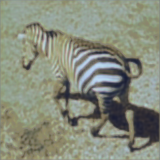

In [56]:
toIMG(a2[0][0])

### Trainning

In [11]:
from torch.nn import MSELoss

In [12]:
mse = MSELoss()

#### GAN Loss

$\large L_{GAN}(G,D_{Y},X,Y) = {\mathbb E}_{y \tilde{} p_{Data}(y)} [logD_{Y}(y)] +  {\mathbb E}_{x \tilde{} p_{Data}(x)} [log(1-D_{Y}(G(x)))]$

$\large L_{GAN}(F,D_{X},Y,X) = {\mathbb E}_{x \tilde{} p_{Data}(x)} [logD_{X}(x)] +  {\mathbb E}_{y \tilde{} p_{Data}(y)} [log(1-D_{X}(F(y)))]$

But in paper's experiment section, it adopted a more practical loss function

For GAN loss, $\large L_{GAN}(G,D_{Y},X,Y)$, we train $\large G$ to minimize $\large {\mathbb E}_{x \tilde{} p_{Data}(x)} [(D_{Y}(G(x))-1)^{2}]$. This is the loss function we actually coded

#### Cycle Consistency Loss

$\large L_{cyc}(G,F) = {\mathbb E}_{x \tilde{} p_{Data}(x)}[||F(G(x))-x||_{1}] + {\mathbb E}_{y \tilde{} p_{Data}(y)}[||G(F(y))-y||_{1}]$

#### Full Objective

$\large L(G,F,D_{X},D_{Y}) =  L_{GAN}(G,D_{Y},X,Y) + L_{GAN}(F,D_{X},Y,X) + \lambda L_{cyc}(G,F)$

In [13]:
import os
from datetime import datetime
from p3self.matchbox import clip_weight

os.system("mkdir -p /data")
os.system("mkdir -p /data/forge")
os.system("mkdir -p /data/forge/"+trainA)
os.system("mkdir -p /data/forge/"+trainB)
toIMG = transforms.ToPILImage()

class to_images(Dataset):
    def __init__(self,tensors,dir_,batch_size=2):
        super(to_images,self).__init__()
        self.tensors = tensors
        self.len = self.tensors.size()[0]
        if dir_[-1]!="/":dir_=dir_+"/"
        self.dir_=dir_
        self.batch_size=batch_size
        self.dl=DataLoader(self,batch_size=batch_size,shuffle=True)
    
    def adapt(self,tensors):
        self.tensors = tensors
        self.len = self.tensors.size()[0]
        gen=iter(self.dl)
        for i in range(len(self.dl)):
            ret = next(gen)
        
    def __len__(self):
        return self.len
        
    def __getitem__(self,idx):
        img = toIMG(self.tensors[idx])
#         now=datetime.now().strftime("%M_%S_%f")
#         img.save(self.dir_+now+"_"+str(idx)+".png")
        now=datetime.now().strftime("%S")
        img.save(self.dir_+now+"_"+str(idx)+".png")
        return 1

#### Image Saving

In [14]:
saveX = to_images(torch.rand(2,3,HEIGHT,WIDTH),forge+trainA)
saveY = to_images(torch.rand(2,3,HEIGHT,WIDTH),forge+trainB)

In [15]:
def loss_D(D,real,fake):
    """
    loss of discriminator
    D: the dsicriminative model
    real: image from dataset
    fake: the generated image
    """
    dt = torch.cat([real,fake],dim=0)
    y_ = D(dt)
    y = torch.cat([torch.ones(real.size()[0],1),torch.zeros(fake.size()[0],1)],dim=0)
    if CUDA:
        y = y.cuda()
    return torch.pow(y_-y,2).mean()

def train_D(X,Y,past_X = None,past_Y = None,):
    Y_ = c.G_x(X)
    X_ = c.G_y(Y)
    
    if past_X:
        X_fake = torch.cat([X_,past_X],dim = 0)
        Y_fake = torch.cat([Y_,past_Y],dim = 0)
    
    loss_D_x = loss_D(D = c.D_x, real = X, fake = X_fake)
    loss_D_y = loss_D(D = c.D_y, real = Y, fake = Y_fake)
    
    loss_D_x.backward()
    loss_D_y.backward()
    
    c.opt_Dx.step()
    c.opt_Dy.step()
    
    # Save the generated images
    if CUDA:
        X_,Y_ = X_.cpu(),Y_.cpu()
        X_c,Y_c = X.clone().cpu(),Y.clone().cpu()
    else:
        X_c,Y_c = X.clone(),Y.clone()
        
    saveX.adapt(torch.cat([X_,Y_c],dim = 2))
    saveY.adapt(torch.cat([Y_,X_c],dim = 2))
    
    return loss_D_x,loss_D_y

def train_G(X,Y,lbd = 1e1):
    # formula #3 in paper
    L_gan_y = torch.pow(c.D_y(c.G_x(X))-1,2).mean()
    L_gan_x = torch.pow(c.D_x(c.G_y(Y))-1,2).mean()
    L_cycle = torch.abs(c.G_y(c.G_x(X))-X).mean() + torch.abs(c.G_x(c.G_y(Y))-Y).mean()
    
    Loss = L_gan_y + L_gan_x + lbd*L_cycle
    
    Loss.backward()
    c.opt_G.step()
    
    return Loss,L_gan_y,L_gan_x,L_cycle
    
def action(*args,**kwargs):
    X,Y = args[0]
    ite = kwargs["ite"]
    ep = kwargs["epoch"]
    if CUDA:
        X,Y = X.cuda(),Y.cuda()
    if ite == 100 & epoch ==0:
        ds_past = data_cg_past(forge+"trainA/",forge+"trainB/")
        dl_past = DataLoader(ds_past,batch_size=int(self.batch_szie/2),shuffle=True)
        gen_past = iter(dl_past)
       
    c.zero_grad()
    
    if ite>100 or epoch>0:
        past_X,past_Y=next(gen_past)
        if CUDA:
            past_X,past_Y=past_X.cuda(),past_Y.cuda()
        loss_D_x,loss_D_y = train_D(X,Y,past_X,past_Y)
    else:    
        loss_D_x,loss_D_y = train_D(X,Y)
    
    if ite%5==0:
        c.zero_grad()
        Loss,L_gan_y,L_gan_x,L_cycle = train_G(X,Y,lbd=10)
    else:
        zero=torch.zeros(1)
        Loss = zero
        L_gan_y = zero
        L_gan_x = zero
        L_cycle = zero
    clip_weight(c.D_x,1e-2)
    clip_weight(c.D_y,1e-2)
    
    if ite%10==9:
        c.save()
    return {"loss_D_x":loss_D_x.item(),
            "loss_D_y":loss_D_y.item(),
            "Loss":Loss.item(),
            "L_gan_y":L_gan_y.item(),
            "L_gan_x":L_gan_x.item(),
            "L_cycle":L_cycle.item(),}
    

Pytorch training framework [matchbox](https://raynardj.github.io/p3self/docs/matchbox)

In [16]:
from p3self.matchbox import Trainer

In [17]:
trainer=Trainer(data_cg(DATA+"trainA/",DATA+"trainB/"),batch_size=BS,print_on=5)
trainer.action = action

In [18]:
c.load()

In [19]:
os.system("rm -rf %s"%(forge+trainA+"*"))
os.system("rm -rf %s"%(forge+trainB+"*"))

0

In [20]:
trainer.train(10)

⭐[ep_0_i_804]	L_cycle	0.028✨	L_gan_x	0.191✨	L_gan_y	0.191✨	Loss	0.657✨	loss_D_x	0.477✨	loss_D_y	0.479:  64%|██████▍   | 805/1250 [17:09<09:28,  1.28s/it]

KeyboardInterrupt: 

In [ ]:
c.save()

In [16]:
a=torch.rand(2,3,160,160)
b=torch.rand(2,3,160,160)
a=torch.cat([a,b],dim=0)
a.size()

torch.Size([4, 3, 160, 160])